In [2]:
# import utility libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import string
import spacy # TO MOTIVATE
nlp = spacy.load('it_core_news_sm')
from nltk.stem import SnowballStemmer # TO MOTIVATE
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
import re
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import csv
import emoji
from sklearn.model_selection import cross_val_score



%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

In [3]:
# read csv files
df_train = pd.read_csv('./data/development.csv', sep = ',')
df_test = pd.read_csv('./data/evaluation.csv', sep = ',')

x_train = df_train['text']
y_train = df_train['class']

x_test = df_test['text']

In [4]:
# STEP. 1: DATA EXPLORATION

# i have no missing values in my development set
print(df_train.isnull().sum())
print(df_test.isnull().sum())

text     0
class    0
dtype: int64
text    0
dtype: int64


In [5]:
print(df_train.isnull().sum())
print(df_train.info())
print(df_train.head())
print(df_train.describe())

text     0
class    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28754 entries, 0 to 28753
Data columns (total 2 columns):
text     28754 non-null object
class    28754 non-null object
dtypes: object(2)
memory usage: 449.4+ KB
None
                                                text class
0  Non è l'hotel più lussuoso in cui abbia mai so...   pos
1  Siamo stati qui per 1 notte prima della nostra...   pos
2  Hotel è ben posizionato per visitare Torino. A...   pos
3  All'arrivo la cordialità e disponibilità dello...   pos
4  Abbiamo soggiornato per due notti alla fine de...   pos
                                                     text  class
count                                               28754  28754
unique                                              28754      2
top     Come accennavo nel titolo vista mozzafiato (ma...    pos
freq                                                    1  19532


In [6]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28754 entries, 0 to 28753
Data columns (total 2 columns):
text     28754 non-null object
class    28754 non-null object
dtypes: object(2)
memory usage: 449.4+ KB
None


pos    19532
neg     9222
Name: class, dtype: int64


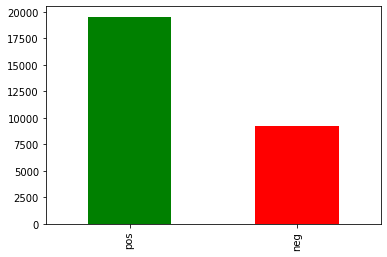

In [40]:
# problem balanced? there are a lot more positive reviews rather than negative in the training set
# => problem not balanced
print(df_train['class'].value_counts())
df_train['class'].value_counts().plot(kind='bar', color = ['green', 'red'])

624.5674278107721
58
7800
513.6230925334596

864.228475384949
67
9153
740.8239343333894


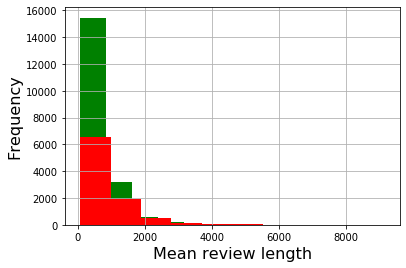

In [47]:
# mean review length
# positive mean length
aus = df_train.loc[df_train['class'] == 'pos']
# characterizing distribution
print(aus.text.str.len().mean())
print(aus.text.str.len().min())
print(aus.text.str.len().max())
print(aus.text.str.len().std())
plt.figure();
plt.xlabel("Mean review length", fontsize=16)  
plt.ylabel("Frequency", fontsize=16)
aus.text.str.len().hist(color = 'green', label = 'positive')

print()

# negative mean length
aus = df_train.loc[df_train['class'] == 'neg']
# characterizing distribution
print(aus.text.str.len().mean())
print(aus.text.str.len().min())
print(aus.text.str.len().max())
print(aus.text.str.len().std())
aus.text.str.len().hist(color = 'red', label = 'negative')

# insight: negative reviews are generally longer

In [9]:
# STEP 2: PREPROCESSING

# 2.1 create dictionary of words (useful in later lemmatization)


# input: pandas Series of reviews
# output: pandas dataframe, columns: base form (word from review), POS, lemma
def createDictionaryFromReviews(x_train):
    all_reviews =""
    for row in x_train.iteritems(): 
        review = row[1]
        invalid = string.punctuation + '\n'
        translator = str.maketrans(invalid, ' '*len(invalid)) #map punctuation to space
        review = review.translate(translator)
        all_reviews += review.lower() + " " 

    set_of_words = set(all_reviews.split(" "))
    list_set_of_words = list(set_of_words)
    str_set_of_words = "";
    str_set_of_words = ' '.join(list_set_of_words)

    list_myvocabulary = [(x.text,x.pos_,x.lemma_) for x in nlp(str_set_of_words)]
    my_vocabulary = pd.DataFrame(list_myvocabulary, columns = ['base', 'pos', 'lemma'])
    my_vocabulary = my_vocabulary.drop_duplicates(subset=['base'])
    return my_vocabulary
    
my_vocabulary = createDictionaryFromReviews(x_train)

# create dictionary of lemmas and pos => dictionary is very fast to query
# key = base word, value = lemma
my_dict_lemmas = {row[0]: row[2] for row in my_vocabulary.values}

# key = base word, value = pos
my_dict_pos = {row[0]: row[1] for row in my_vocabulary.values}

In [35]:
# 2.2 tokenization

# keep only words with vowels
def hasVowels(inputString):
    vowels = {"a", "e", "i", "o", "u", "A", "E", "I", "O", "U"}
    return any(char in vowels for char in inputString)

# keep only words
def isAlphabetical(inputString):
    regex = '^[A-Za-z]+$'
    return bool(re.match(regex, inputString))

class LemmaTokenizer(object):
    def __call__(self, document): 
        lemmas = []
        
        # replace all punctuations with whitespace
        translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
        document.translate(translator)
        
        for t in word_tokenize(document):
            # remove initial and final spaces
            t = t.strip()
            t = t.lower()
            valid = True
            # emojis may be useful
            if (t in set(emoji.UNICODE_EMOJI)):
                emoji_to_text = emoji.demojize(t).replace(":","")
                lemmas.append(emoji_to_text)
            else:
                # do not consider these type of 'stopwords'
                # italian dictionary PRACTICALLY hasnt word longer than 16 chars
                # i'm not interested in very short words (most of them are stopwords)
                if (not hasVowels(t) or len(t) < 3 or len(t) > 16 or not isAlphabetical(t)):
                    valid = False
                else:
                    # retrieve lemma from base form using dictionary
                    if (t in my_dict_lemmas.keys()):
                        lemma = my_dict_lemmas[t]
                        lemmas.append(lemma)
        return lemmas

list_sw_bigram = ['essere','avere', 'dare','fare', 'stare', 'stesso', 'fossa', 'fosso']
#list_sw_bigram =  ['aglio', 'avere', 'dare', 'essere', 'facciata', 'fare', 'fossa', 'fosso', 'stare', 'stesso', 'torre']
stopwords = sw.words('italian') + list_sw_bigram
to_remove_from_sw = ['non', 'contro', 'tutto']
[stopwords.remove(el) for el in to_remove_from_sw]

tokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(tokenizer = tokenizer,stop_words=stopwords,encoding='utf-8',lowercase=True, min_df = 1, max_df = 0.7, ngram_range = (1,2), strip_accents = 'unicode', sublinear_tf = True, use_idf = True, analyzer='word') 

# train
X_tfidf = vectorizer.fit_transform(x_train)

# test
X_tfidf_test = vectorizer.transform(x_test)

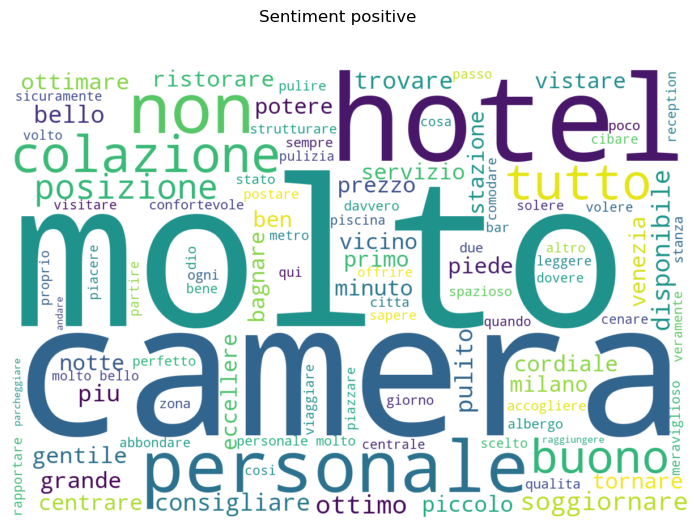

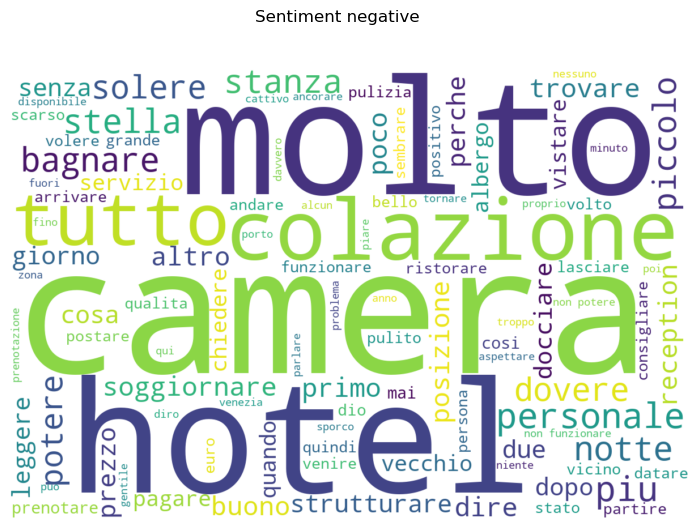

In [11]:
# 2.4 generate wordclouds for positive and negative reviews
def generate_wordclouds(my_tf_idf, word_positions, sentiment):
    top_count = 100
    tfidf = my_tf_idf
    tfidf_sum = np.sum(tfidf, axis=0) # numpy.matrix
    tfidf_sum = np.asarray(tfidf_sum).reshape(-1) # numpy.array of shape (1, X.shape[1])
    top_indices = tfidf_sum.argsort()[-top_count:]
    term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}
    wc = WordCloud(width=1200, height=800, background_color="white")
    wordcloud = wc.generate_from_frequencies(term_weights)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off") 
    fig.suptitle(f"Sentiment {sentiment}")

df_train_pos = df_train.loc[df_train['class'] == 'pos']
x_pos = df_train_pos['text']
X_tfidf_pos = vectorizer.fit_transform(x_pos)
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()} 

# generate wordclouds for positive reviews
generate_wordclouds(X_tfidf_pos, word_positions, "positive")

df_train_neg = df_train.loc[df_train['class'] == 'neg']
x_neg = df_train_neg['text']
X_tfidf_neg = vectorizer.fit_transform(x_neg)

word_positions = {v: k for k, v in vectorizer.vocabulary_.items()} 

# generate wordclouds for negative reviews
generate_wordclouds(X_tfidf_neg, word_positions, "negative")

In [36]:
# useful in tests
#classifier_linear = svm.LinearSVC(**param_grid)
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
y_train_encoded= lb_make.fit_transform(y_train)

In [37]:
# Select the best parameters for classificator
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
classifier_linear = svm.LinearSVC()
param_grid = { 'C': [0.1,0.8, 1, 1.2, 1.4, 1.6, 10],  
               'penalty': ['l1', 'l2'],
               'loss': ['squared_hinge', 'hinge'],
                'fit_intercept': [True, False],
               'class_weight': ['balanced', {'pos': 1/3, 'neg': 2/3}]
             }  
  
grid = GridSearchCV(classifier_linear, param_grid, refit = True, verbose = 1, scoring='f1') 
  
# fitting the model for grid search 
grid.fit(X_tfidf, y_train_encoded) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFai

{'C': 1.4, 'class_weight': 'balanced', 'fit_intercept': True, 'loss': 'hinge', 'penalty': 'l2'}
LinearSVC(C=1.4, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [38]:
# STEP 3.2 - Classification - SVM

classifier_linear = svm.LinearSVC(**grid.best_params_)
classifier_linear.fit(X_tfidf, y_train)

y_pred_svm = classifier_linear.predict(X_tfidf_test)
dumpToFile(y_pred_svm, "submission_svm.csv")

In [15]:
# evalueted score
#from sklearn.metrics import f1_score
#f1_score(y_true, y_pred, average='weighted')

Number of components = 10 and explained variance = 0.009755658636795965
Number of components = 20 and explained variance = 0.015169845270080383
Number of components = 30 and explained variance = 0.01975218333323487
Number of components = 40 and explained variance = 0.02384475658662579
Number of components = 50 and explained variance = 0.027616202765831155


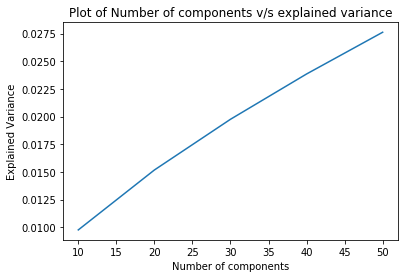

In [16]:
# Dimensionality reduction -  svd for sparse matrices
from sklearn.decomposition import TruncatedSVD


# Program to find the optimal number of components for Truncated SVD
n_comp = [10, 20,30,40,50]#,1500,2000,2500,3000,3500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_tfidf)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

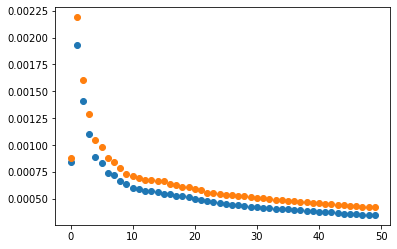

In [17]:
from sklearn.decomposition import TruncatedSVD

def dimensionalityReduction(data, components):
    svd = TruncatedSVD(n_components=components, random_state=42)
    reduced_data = svd.fit_transform(data)
    plt.plot(svd.explained_variance_ratio_, marker='o', linestyle='')
    return reduced_data

n_components = 50
# train
X_tfidf_red = dimensionalityReduction(X_tfidf, n_components)

#test
x_tf_idf_test = vectorizer.fit_transform(x_test)
X_tfidf_test_red = dimensionalityReduction(x_tf_idf_test, n_components)

In [ ]:
# Step 3: classification

# 3.1
# STEP 3.1 - Classification - RANDOM FOREST
best_config = {
 'class_weight':"balanced",
 'n_estimators': 100,
 'random_state': 42
}

model = RandomForestClassifier(**best_config)
model.fit(X_tfidf_red, y_train)

f1_forest = cross_val_score(model, X_tfidf_red, y_train_encoded, cv=5, scoring='f1')
print(f1_forest)

y_pred_forest = model.predict(X_tfidf_test_red)
dumpToFile(y_pred_forest, "submission_forest.csv")

[0.97760717 0.97937882 0.9733112  0.9735057  0.97613883]


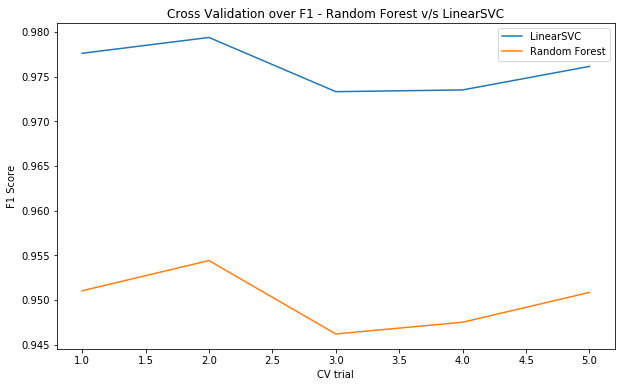

In [39]:
# test on training set
  
f1_linearsvc = cross_val_score(classifier_linear, X_tfidf, y_train_encoded, cv=5, scoring='f1')
print(f1_linearsvc)

x = [1, 2, 3, 4, 5]
y_svc = f1_linearsvc
y_forest = f1_forest
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x,y_svc)
ax.plot(x,y_forest)
plt.title("Cross Validation over F1 - Random Forest v/s LinearSVC")
plt.xlabel('CV trial')
plt.ylabel("F1 Score")
ax.legend(['LinearSVC', 'Random Forest'])
plt.show()

# [0.97760717 0.97937882 0.9733112  0.9735057  0.97626946]

In [20]:
# writing the submission file (may be optimized using pandas)

def dumpToFile(predictions, filename):
    index = 0
    with open(filename, encoding = 'utf-8', mode='w') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Id", "Predicted"])
        for pred in predictions:
            writer.writerow([index, pred])
            index += 1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score

X_train,X_test,Y_train,Y_test = train_test_split(X_tfidf,y_train,test_size=0.2,random_state=1000)
solution = classifier_linear.predict(X_test)
f1_score(Y_test, solution, average='weighted')

In [21]:
"""for k,v in my_dict_pos.items():
    if (v == 'X'):
        print(k)"""

"for k,v in my_dict_pos.items():\n    if (v == 'X'):\n        print(k)"

In [22]:
"""import sklearn.naive_bayes
from sklearn.naive_bayes import MultinomialNB

Naive = naive_bayes.MultinomialNB()
Naive.fit(X_tfidf,y_train_encoded)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_tfidf_test)
# Use accuracy_score function to get the accuracy
#print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)"""

'import sklearn.naive_bayes\nfrom sklearn.naive_bayes import MultinomialNB\n\nNaive = naive_bayes.MultinomialNB()\nNaive.fit(X_tfidf,y_train_encoded)\n# predict the labels on validation dataset\npredictions_NB = Naive.predict(X_tfidf_test)\n# Use accuracy_score function to get the accuracy\n#print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)'

In [23]:
"""#Importing MLPClassifier
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

#Fitting the training data to the network
classifier.fit(X_tfidf, y_train_encoded)

#Predicting y for X_val
y_pred = classifier.predict(X_tfidf_test)

f1 = cross_val_score(classifier, X_tfidf, y_train_encoded, cv=5, scoring='f1')
print(f1)"""

"#Importing MLPClassifier\nfrom sklearn.neural_network import MLPClassifier\n\n#Initializing the MLPClassifier\nclassifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)\n\n#Fitting the training data to the network\nclassifier.fit(X_tfidf, y_train_encoded)\n\n#Predicting y for X_val\ny_pred = classifier.predict(X_tfidf_test)\n\nf1 = cross_val_score(classifier, X_tfidf, y_train_encoded, cv=5, scoring='f1')\nprint(f1)"

In [49]:
"""from sklearn import linear_model

param_grid = { 'C': [0.1,0.8, 1, 1.2, 1.4, 1.6, 10],  
               'penalty': ['l1', 'l2'],
               'loss': ['squared_hinge', 'hinge'],
                'fit_intercept': [True, False],
               'class_weight': ['balanced', {'pos': 1/3, 'neg': 2/3}]
             }  

clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_tfidf, y_train_encoded)
clf.predict(X_tfidf_test)

f1 = cross_val_score(clf, X_tfidf, y_train_encoded, cv=5, scoring='f1')
print(f1)"""

[0.97657245 0.97607898 0.96971233 0.97117347 0.97195787]
